In [4]:
%load_ext autoreload

In [5]:
%autoreload 2

import cebra
from copy import deepcopy
import itertools
from matplotlib.cm import get_cmap, ScalarMappable
from matplotlib import colors
from matplotlib.colors import Normalize
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy
from sklearn.decomposition import PCA
from sklearn import manifold
import sys
import torch
from tqdm.notebook import tqdm

plt.style.use('/om2/user/eisenaj/code/ChaoticConsciousness/sci_style.py')

sys.path.append('../..')
from data_utils import get_data_class, load_session_data, load_window_from_chunks, combine_grid_results

sys.path.append('/om2/user/eisenaj/code/DeLASE')
from delase import *
from dmd import embed_signal_torch
from utils import numpy_torch_conversion

In [6]:
def get_section(t, section_times):
    for section, bounds in section_times.items():
        if t >= bounds[0] and t < bounds[1]:
            return section

# Load Data

In [335]:
# session = 'MrJones-Anesthesia-20160109-01'
# session = 'MrJones-Anesthesia-20160210-01'
start_times = np.int0(np.hstack([np.linspace(1600, 2300, 15), np.linspace(2700, 3250, 12), np.linspace(3500, 4200, 15), np.linspace(5000, 5700, 15), np.linspace(6500, 7000, 11)]))
session = 'Mary-Anesthesia-20160912-02'
results_dir = '/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/session_results'

In [336]:
all_data_dir = '/scratch2/weka/millerlab/eisenaj/datasets/anesthesia/mat'
data_class = get_data_class(session, all_data_dir)

os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
# variables = ['electrodeInfo', 'lfp', 'lfpSchema', 'sessionInfo', 'trialInfo', 'unitInfo']
# session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
# electrode_info, lfp, lfp_schema, session_info, trial_info, unit_info = session_vars['electrodeInfo'], session_vars['lfp'], session_vars['lfpSchema'], session_vars['sessionInfo'], session_vars['trialInfo'], session_vars['unitInfo']

variables = ['electrodeInfo', 'lfpSchema', 'sessionInfo', 'spikeTimes', 'trialInfo', 'unitInfo']
session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
electrode_info, lfp_schema, session_info, spike_times, trial_info, unit_info = session_vars['electrodeInfo'], session_vars['lfpSchema'], session_vars['sessionInfo'], session_vars['spikeTimes'], session_vars['trialInfo'], session_vars['unitInfo']

In [337]:
eyes_open = session_info['eyesOpen'][-1] if isinstance(session_info['eyesOpen'], np.ndarray) else session_info['eyesOpen']
eyes_close = session_info['eyesClose'][-1] if isinstance(session_info['eyesClose'], np.ndarray) else session_info['eyesClose']

In [338]:
# section_times = dict( 
#         wake=(0, session_info['drugStart'][0]),
#         induction=(session_info['drugStart'][0], eyes_close),
#         anesthesia=(eyes_close, session_info['drugEnd'][1]),
#         recovery=(session_info['drugEnd'][1], T*dt)
# )

section_times = dict( 
        wake=(0, session_info['drugStart'][0]),
        induction=(session_info['drugStart'][0], eyes_close),
        anesthesia=(eyes_close, session_info['drugStart'][1]),
        late_anesthesia=(session_info['drugStart'][1], session_info['drugEnd'][1]),
        recovery=(session_info['drugEnd'][1], T*dt)
)

sections = list(section_times.keys())

In [345]:
dir_ = f"/scratch2/weka/millerlab/eisenaj/datasets/anesthesia/mat/propofolPuffTone/{session}_lfp_chunked_20s"
directory = pd.read_pickle(os.path.join(dir_, "directory"))

In [339]:
tone_on = trial_info['cpt_toneOn'][~np.isnan(trial_info['cpt_toneOn'])]
tone_off = trial_info['cpt_toneOff'][~np.isnan(trial_info['cpt_toneOff'])]
puff_on = trial_info['cpt_puffOn'][~np.isnan(trial_info['cpt_puffOn'])]
puff_off = trial_info['cpt_puffOff'][~np.isnan(trial_info['cpt_puffOff'])]

In [340]:
section_times

{'wake': (0, 1155.1906666666666),
 'induction': (1155.1906666666666, 1480.6452666666667),
 'anesthesia': (1480.6452666666667, 2955.1906666666664),
 'late_anesthesia': (2955.1906666666664, 4755.977966666667),
 'recovery': (4755.977966666667, 6504.301)}

# Test Out Cebra

In [245]:
from dmd import embed_signal_torch

In [294]:
t = 3400
window = 800

In [295]:
lfp_vals = load_window_from_chunks(t, t + window, directory)
lfp_vals = embed_signal_torch(lfp_vals, n_delays=10)
T = lfp_vals.shape[0]

In [296]:
trial_indices = (trial_info['cpt_refTime'] >= t) & (trial_info['cpt_refTime'] < t + window)
ref_times = trial_info['cpt_refTime'][trial_indices] - t
trial_types = trial_info['cpt_trialType'][trial_indices]

tone_ons = tone_on[(tone_on >= t) & (tone_on <= t + window)] - t
tone_offs = tone_off[(tone_off >= t) & (tone_off <= t + window)] - t
puff_ons = puff_on[(puff_on >= t) & (puff_on <= t + window)] - t
puff_offs = puff_off[(puff_off >= t) & (puff_off <= t + window)] - t

In [297]:
discrete_labels = np.zeros(T)

for t1 in puff_ons:
    # find the puff start and end times
    bools = puff_offs > t1
    if np.sum(bools) == 0:
        t2 = T
    else:
        t2 = puff_offs[bools][0]

    # determine what kind of puff it is
    bools = t1 >= ref_times
    if np.sum(bools) == 0:
        trial_type = trial_info['cpt_trialType'][np.argmax(trial_indices) - 1]
    else:
        trial_type = trial_types[np.where(ref_times == np.max(ref_times[bools]))[0]]

    if trial_type == 'puffOnly':
        discrete_labels[int(t1/dt):int(t2/dt)] = -1
    else: # trial_type == 'tonePuff
        discrete_labels[int(t1/dt):int(t2/dt)] = 1

for t1 in tone_ons:
    # find the puff start and end times
    bools = tone_offs > t1
    if np.sum(bools) == 0:
        t2 = T
    else:
        t2 = tone_offs[bools][0]

    # determine what kind of puff it is
    bools = t1 >= ref_times
    if np.sum(bools) == 0:
        trial_type = trial_info['cpt_trialType'][np.argmax(trial_indices) - 1]
    else:
        trial_type = trial_types[np.where(ref_times == np.max(ref_times[bools]))[0]]

    if trial_type == 'toneOnly':
        discrete_labels[int(t1/dt):int(t2/dt)] = -2
    else: # trial_type == 'tonePuff
        discrete_labels[int(t1/dt):int(t2/dt)] = 2

# add in responses
response_on_inds = response_off_times = np.where(np.diff(np.abs(discrete_labels)) > 0)[0]
response_off_inds = np.where(np.diff(np.abs(discrete_labels)) < 0)[0]
for i in range(len(response_off_inds)):
    t_ = response_off_inds[i]
    # find next_response_on_ind
    bools = response_on_inds > t_
    if np.sum(bools) == 0:
        next_response_on_ind = T
    else:
        next_response_on_ind = response_on_inds[bools][0]

    response_length = 3 # s
    if discrete_labels[t_] == -1: # puffOnly
        discrete_labels[t_ + 1:np.min([t_ + int(response_length/dt), next_response_on_ind])] = -3
    elif discrete_labels[t_] == -2: # toneOnly
        discrete_labels[t_ + 1:np.min([t_ + int(response_length/dt), next_response_on_ind])] = -4
    elif discrete_labels[t_] == 1: # tonePuff puff
        discrete_labels[t_ + 1:np.min([t_ + int(response_length/dt), next_response_on_ind])] = 3
    elif discrete_labels[t_] == 2: # tonePuff tone
        discrete_labels[t_ + 1:np.min([t_ + int(response_length/dt), next_response_on_ind])] = 4


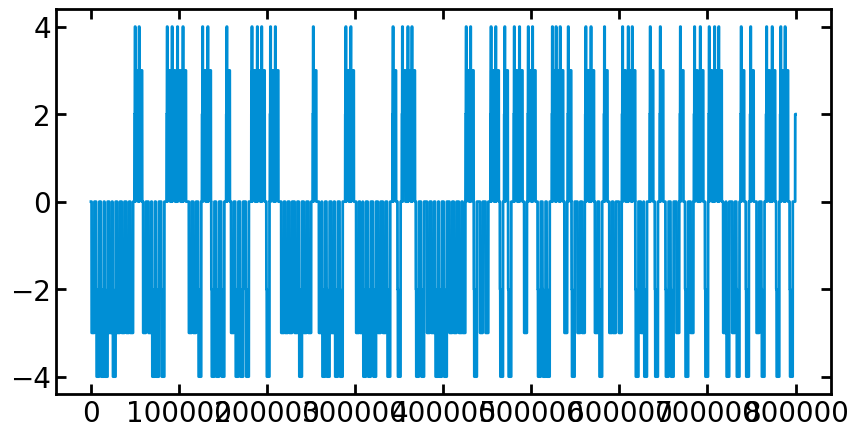

In [298]:
plt.plot(discrete_labels)

In [299]:
cebra_model = cebra.CEBRA(
    model_architecture = "offset10-model",
    batch_size = 512,
    temperature_mode="auto",
    learning_rate = 0.001,
    max_iterations = 100,
    time_offsets = 100,
    output_dimension = 8,
    device = "cuda_if_available",
    conditional='time_delta',
    hybrid=False,
    verbose = True
)

In [300]:
cebra_model.fit(lfp_vals, discrete_labels)

pos:  0.4731 neg:  5.5419 total:  6.0150 temperature:  0.9074: 100%|██████████| 100/100 [00:03<00:00, 30.75it/s]


CEBRA(batch_size=512, conditional='time_delta', learning_rate=0.001,
      max_iterations=100, model_architecture='offset10-model',
      temperature_mode='auto', time_offsets=100, verbose=True)

In [301]:
lfp_embed = cebra_model.transform(lfp_vals)

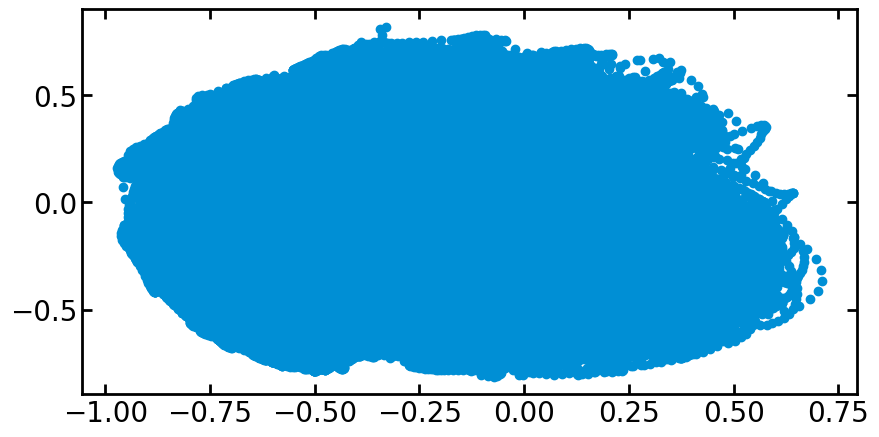

In [302]:
plt.scatter(lfp_embed[:, 0], lfp_embed[:, 1])

In [303]:
color_dict = {
    0: 'black',
    1: 'red',
    2: 'blue',
    3: 'green',
    4: 'orange',
    -1: 'purple',
    -2: 'yellow',
    -3: 'brown',
    -4: 'pink'
}

In [304]:
c = [color_dict[d] for d in discrete_labels]

In [305]:
pca = PCA(n_components=2)
lfp_embed2 = pca.fit_transform(lfp_embed)
pca.explained_variance_ratio_

array([0.1860419 , 0.17866508])

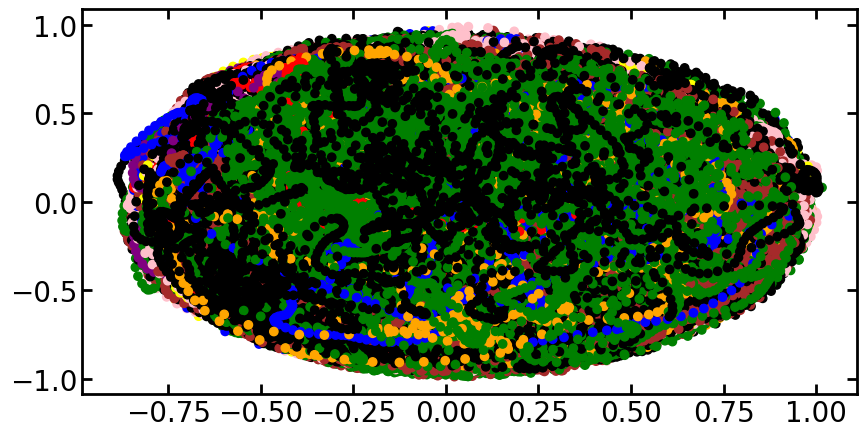

In [279]:
plt.scatter(lfp_embed2[:, 0], lfp_embed2[:, 1], c=c)

In [280]:
pca = PCA(n_components=3)
lfp_embed3 = pca.fit_transform(lfp_embed)
pca.explained_variance_ratio_

array([0.21625781, 0.21486161, 0.19334552])

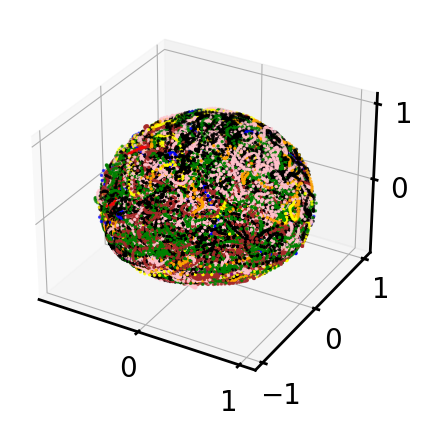

In [281]:
ax = plt.figure().add_subplot(projection='3d')
ax.scatter(lfp_embed3[:, 0], lfp_embed3[:, 1], lfp_embed3[:, 2], s=2, c=c)

# Align Each TRIAL EMBEDDED Trajectory to all others within a section/trial_type

In [285]:
all_embedded_signals = {t: lfp_embed2}
start_times = [t]
subsample = 1

In [306]:
all_embedded_signals[t] = lfp_embed2
start_times.append(t)

In [315]:
response_length = 3 # s

leadin = 0.5 # s
leadout = 0.5 # s

trial_emb_signals = {}
trial_emb_signals_se = {}
for section in section_times.keys():
    trial_emb_signals[section] = {}
    trial_emb_signals_se[section] = {}
    for trial_type in np.unique(trial_info['cpt_trialType']):
        trial_emb_signals[section][trial_type] = None
        trial_emb_signals_se[section][trial_type] = None

for t in start_times:
    section = get_section(t, section_times)
    trial_indices = (trial_info['cpt_refTime'] >= t) & (trial_info['cpt_refTime'] < t + window)
    ref_times = trial_info['cpt_refTime'][trial_indices]
    trial_types = trial_info['cpt_trialType'][trial_indices]

    for i, trial_type in enumerate(np.unique(trial_types)):
        trial_locs = np.int0((ref_times[trial_types == trial_type] - t)*(1/dt)/subsample)
        for loc in trial_locs:
            loc_emb_signal = all_embedded_signals[t][loc - int(leadin/(dt*subsample)):loc + int(response_length/(dt*subsample)) + int(leadout/(dt*subsample))]
            if loc_emb_signal.shape[0] == int(response_length/(dt*subsample)) + int((leadin + leadout)/(dt*subsample)):
                loc_emb_signal = np.expand_dims(loc_emb_signal, 0)
                if trial_emb_signals[section][trial_type] is None:
                    trial_emb_signals[section][trial_type] = loc_emb_signal
                else:
                    trial_emb_signals[section][trial_type] = np.concatenate([trial_emb_signals[section][trial_type], loc_emb_signal])

# COMPUTE MEANS AND SE
for section in trial_emb_signals.keys():
    for trial_type in trial_emb_signals[section].keys():
        if trial_emb_signals[section][trial_type] is not None:
            num_trials = trial_emb_signals[section][trial_type].shape[0]
            print(num_trials)
            standardized_signals = np.zeros(trial_emb_signals[section][trial_type].shape)
            for trial_num in range(1, num_trials):
                mtx1, mtx2, _ = scipy.spatial.procrustes(trial_emb_signals[section][trial_type][0], trial_emb_signals[section][trial_type][trial_num])
                
                # R, scale = scipy.linalg.orthogonal_procrustes(trial_emb_signals[section][trial_type][trial_num], trial_emb_signals[section][trial_type][0])
                # mtx1 = trial_emb_signals[section][trial_type][0]
                # mtx2 = trial_emb_signals[section][trial_type][trial_num] @ R
                
                if i == 1:
                    standardized_signals[0] = mtx1
                standardized_signals[trial_num] = mtx2

            trial_emb_signals[section][trial_type] = standardized_signals.mean(axis=0)
            trial_emb_signals_se[section][trial_type] = standardized_signals.std(axis=0) / np.sqrt(num_trials)

47
54
49
44
51
54


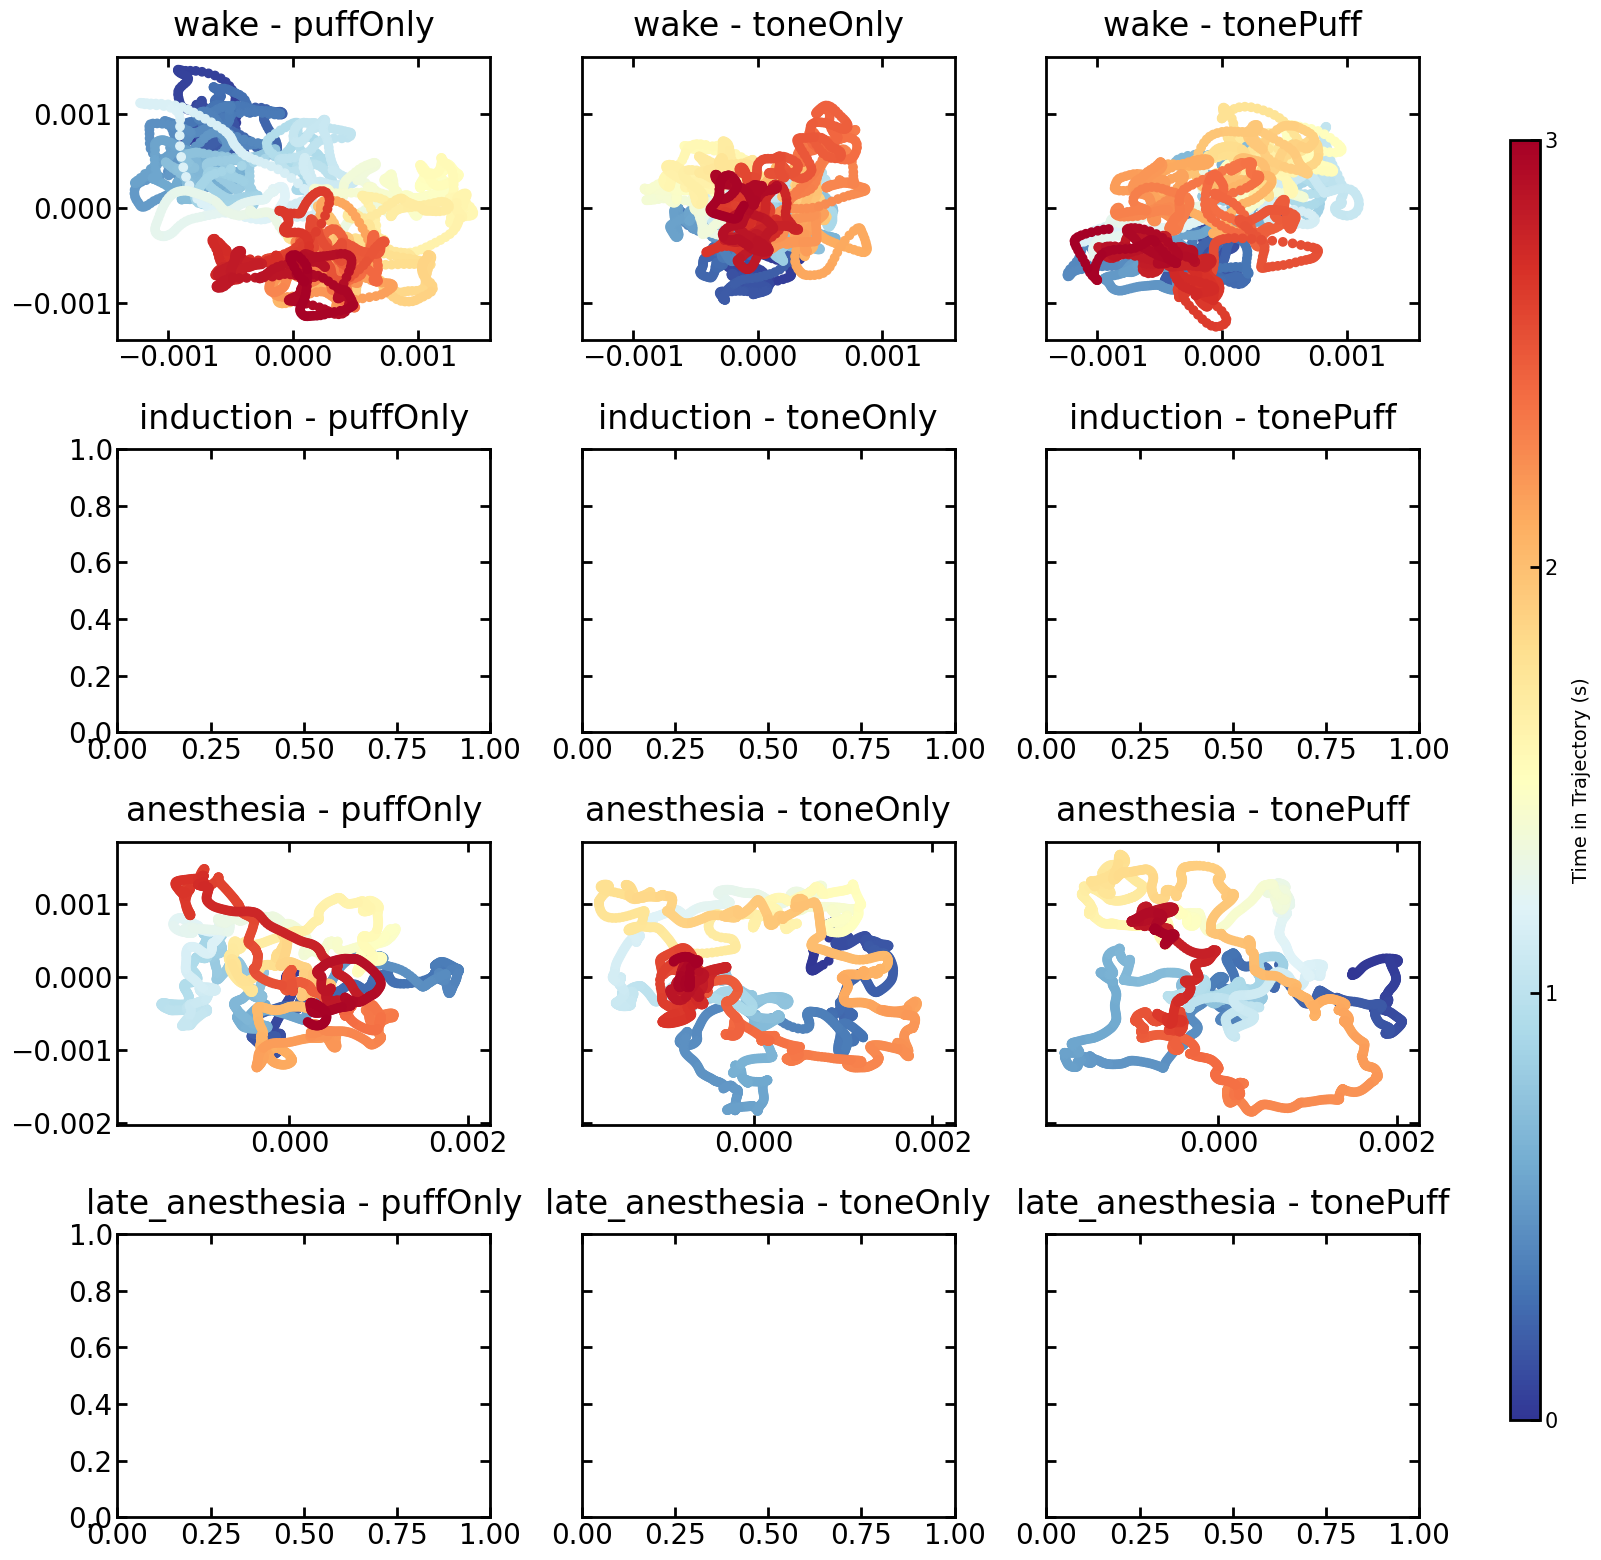

In [317]:
response_length = 3 # s

cmap = plt.cm.get_cmap('RdYlBu_r')
# color_list = cmap(np.linspace(0, 1, int(response_length/(dt*subsample))))
color_list = cmap(np.linspace(0, 1, int(response_length/(dt*subsample)) + int((leadin + leadout)/(dt*subsample))))

# fig = plt.figure(layout='constrained', figsize=(15, 8))
# subfigs = fig.subfigures(2, 1, wspace=0.07)

# plot_sections = ['wake', 'anesthesia']
plot_sections = ['wake', 'induction', 'anesthesia', 'late_anesthesia']

fig, axs = plt.subplots(len(plot_sections), 3, sharey='row', sharex='row', figsize=(15, 4*len(plot_sections)))

for j, section in enumerate(plot_sections):

    # axs = subfigs[num].subplots(1, 3, sharey='row')
    # axs = subfigs[num].subplots(1, 3)

    for i, trial_type in enumerate(np.unique(trial_info['cpt_trialType'])):
        ax = axs[j][i]

        if trial_emb_signals[section][trial_type] is not None:
            ax.scatter(trial_emb_signals[section][trial_type][:, 0], trial_emb_signals[section][trial_type][:, 1], c=color_list)

        # for t in range(trial_emb_signals[section][trial_type].shape[0]):
        #     ellipse = Ellipse(xy=trial_emb_signals[section][trial_type][t, :2], width=trial_emb_signals_se[section][trial_type][t, 0], height=trial_emb_signals_se[section][trial_type][t, 1], 
        #                 edgecolor='none', fc=color_list[t], alpha=0.1)
        #     ax.add_patch(ellipse)

        ax.set_title(f"{section} - {trial_type}")

    # subfigs[num].suptitle(section)
    # subfigs[t_num].tight_layout()

sm = plt.cm.ScalarMappable(cmap=cmap)
plt.tight_layout()
# fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([1.02, 0.1, 0.02, 0.8])
cbar = fig.colorbar(sm, ticks=[0, 0.3333, 0.6666, 1], cax=cbar_ax)
cbar.ax.set_yticklabels([0, 1, 2, 3], fontsize=15)
cbar.set_label('Time in Trajectory (s)', fontsize=14)

plt.show()

## 3D plot

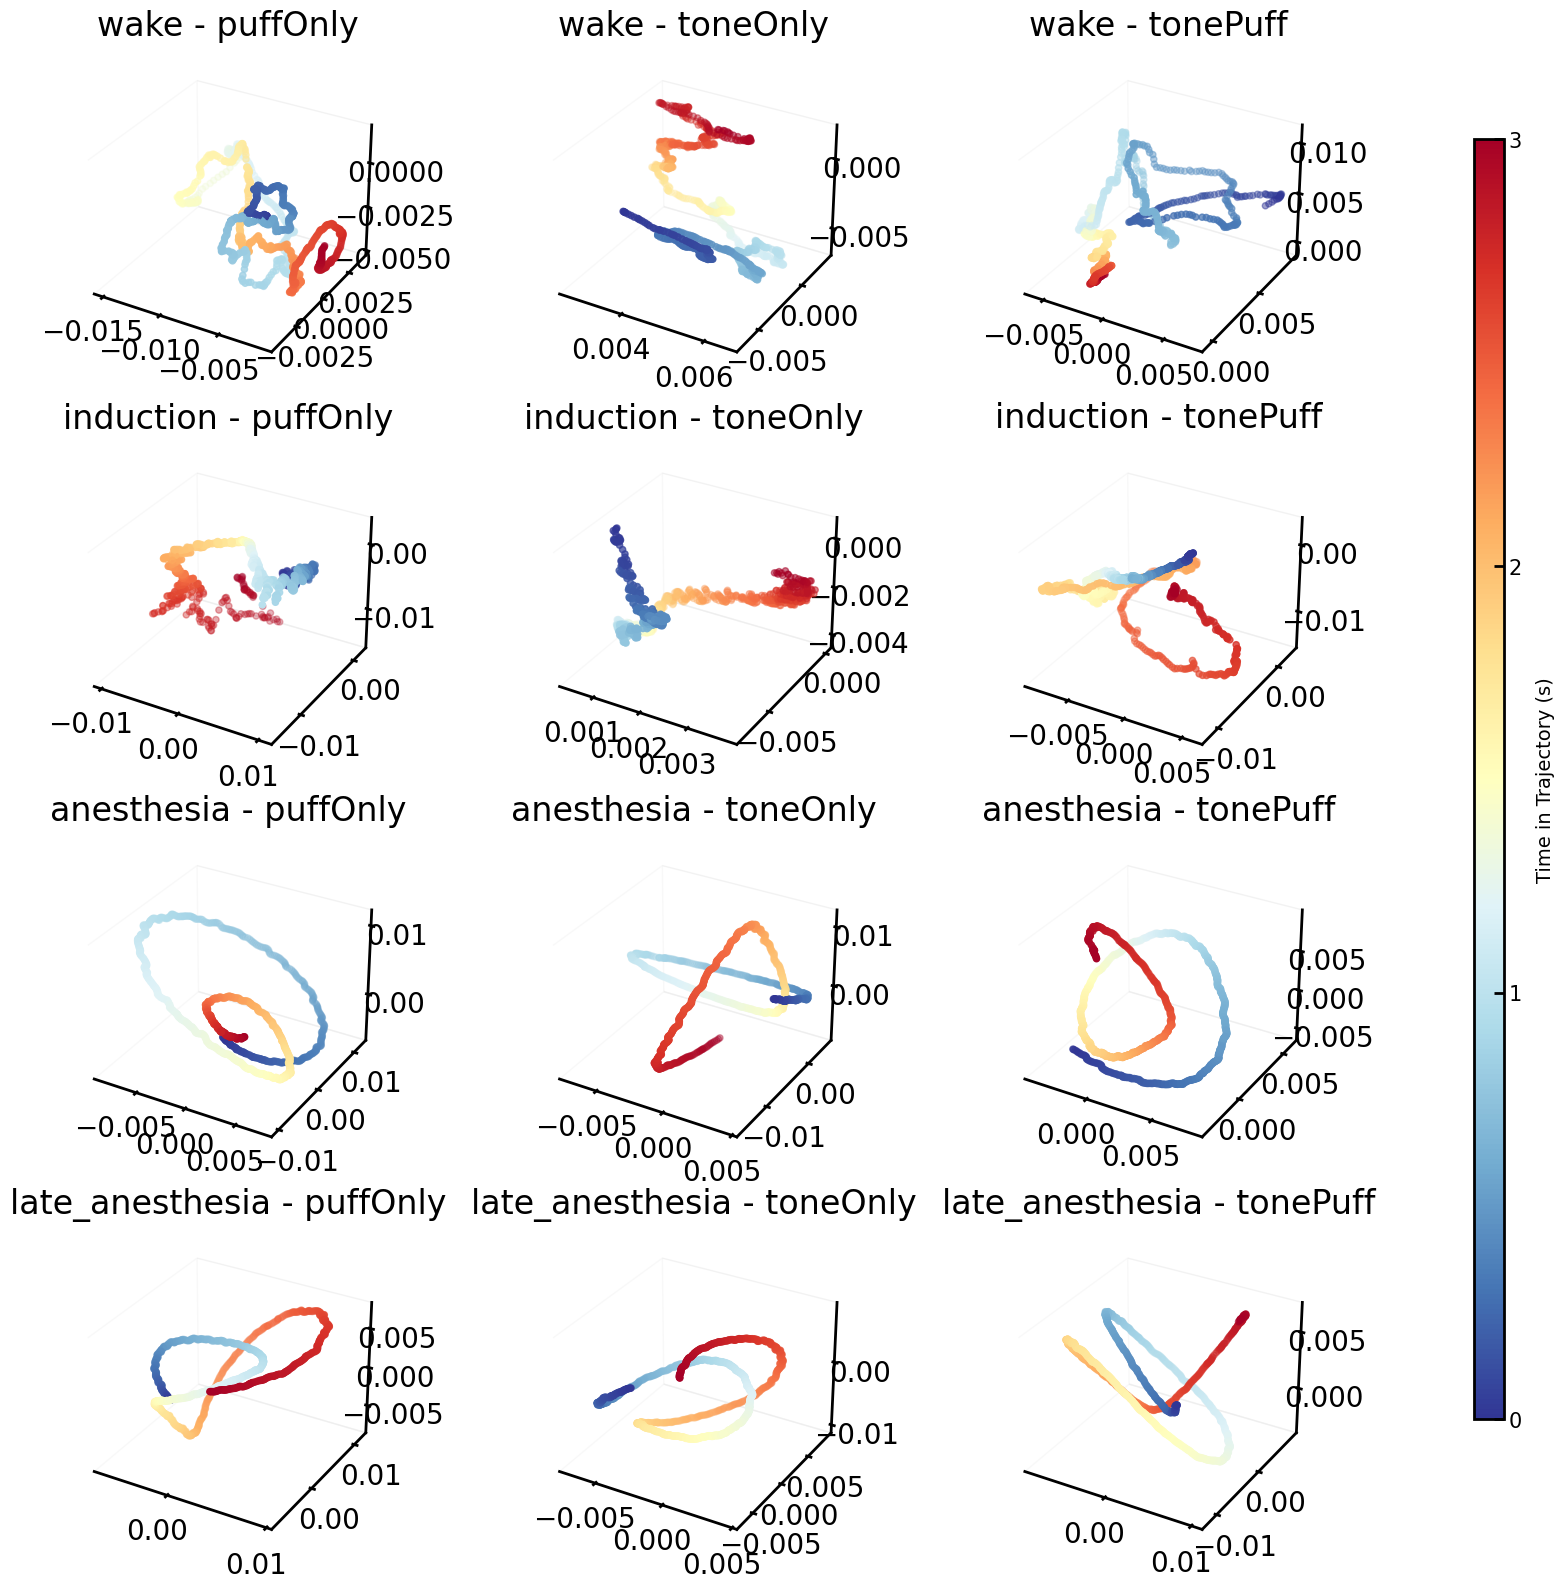

In [47]:
response_length = 3 # s

cmap = plt.cm.get_cmap('RdYlBu_r')
color_list = cmap(np.linspace(0, 1, int(response_length/(dt*subsample))))

# fig = plt.figure(layout='constrained', figsize=(15, 8))
# subfigs = fig.subfigures(2, 1, wspace=0.07)

# plot_sections = ['wake', 'anesthesia']
plot_sections = ['wake', 'induction', 'anesthesia', 'late_anesthesia']

fig, axs = plt.subplots(len(plot_sections), 3, sharey='row', sharex='row', figsize=(15, 4*len(plot_sections)))

for j, section in enumerate(plot_sections):

    # axs = subfigs[num].subplots(1, 3, sharey='row')
    # axs = subfigs[num].subplots(1, 3)

    for i, trial_type in enumerate(np.unique(trial_info['cpt_trialType'])):
        ax = axs[j][i]
        ax.remove()
        ax = fig.add_subplot(len(plot_sections), 3, j*3 + i + 1, projection='3d')
        ax.scatter(trial_emb_signals[section][trial_type][:, 0], trial_emb_signals[section][trial_type][:, 1], trial_emb_signals[section][trial_type][:, 2], c=color_list)
        ax.grid(False)
        ax.w_xaxis.pane.fill = False
        ax.w_yaxis.pane.fill = False
        ax.w_zaxis.pane.fill = False

        # for t in range(trial_emb_signals[section][trial_type].shape[0]):
        #     ellipse = Ellipse(xy=trial_emb_signals[section][trial_type][t, :2], width=trial_emb_signals_se[section][trial_type][t, 0], height=trial_emb_signals_se[section][trial_type][t, 1], 
        #                 edgecolor='none', fc=color_list[t], alpha=0.1)
        #     ax.add_patch(ellipse)

        ax.set_title(f"{section} - {trial_type}")

    # subfigs[num].suptitle(section)
    # subfigs[t_num].tight_layout()

sm = plt.cm.ScalarMappable(cmap=cmap)
plt.tight_layout()
# fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([1.02, 0.1, 0.02, 0.8])
cbar = fig.colorbar(sm, ticks=[0, 0.3333, 0.6666, 1], cax=cbar_ax)
cbar.ax.set_yticklabels([0, 1, 2, 3], fontsize=15)
cbar.set_label('Time in Trajectory (s)', fontsize=14)

plt.show()

# Average of Puff Across Channels

In [346]:
t = 0
window = 1000
lfp_vals = load_window_from_chunks(t, t+window, directory)

In [347]:
lfp_vals.shape

(1000000, 249)

In [348]:
leadin = 2000
leadout = 2000
puffs = np.zeros(leadin + leadout)
count = 0
for puff_t in puff_on:
    if puff_t - dt*leadin >= t and puff_t + dt*leadout < t + window:
        puffs += lfp_vals[int((puff_t -t)/dt) - leadin:int((puff_t - t)/dt) + leadout].sum(axis=1)
        count += lfp_vals.shape[1]
puffs /= count

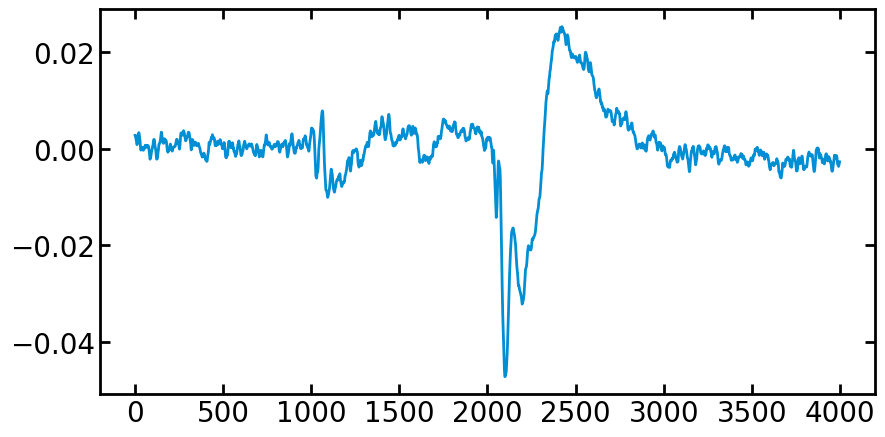

In [349]:
plt.plot(puffs)

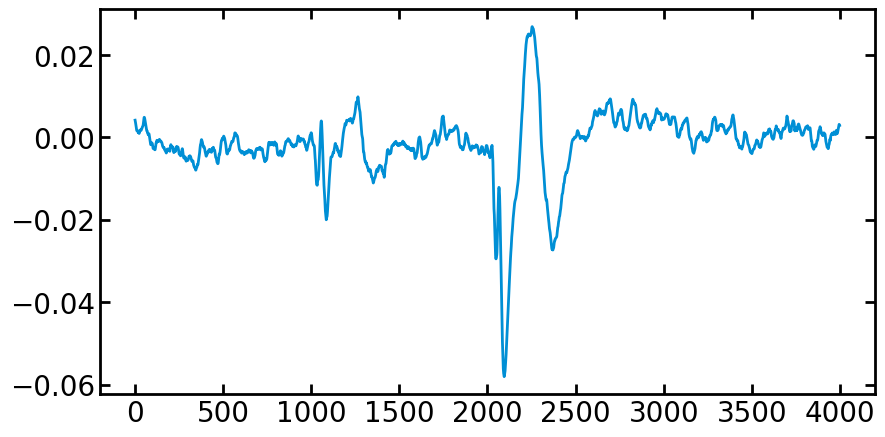

In [334]:
plt.plot(puffs)

In [330]:
t + leadout

3600